### Do NOT click RUN ALL... or else you will spend 20 minutes redefining the embeddings

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
from Bio.Seq import Seq
from transformers import TFBertModel, BertTokenizer,BertConfig
import re
import pickle
import sys
import gc
import os

# np.random.seed(42)
# tf.random.set_seed(42)
# os.environ['PYTHONHASHSEED']=str(42)
tf.keras.utils.set_random_seed(42)


# Defining

Code for ProtBERT and BFD

In [2]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False)
embedding_model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)

2023-02-02 17:01:10.176856: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-02 17:01:10.177010: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [3]:
def get_embeddings(sequence_list):
    # tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False )
    # embedding_model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)
    sequence_list = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequence_list]
    ids = tokenizer.batch_encode_plus(sequence_list, add_special_tokens=True, padding=True, return_tensors="tf")
    input_ids = ids['input_ids']
    attention_mask = np.asarray(ids['attention_mask'])
    embedding = np.asarray(embedding_model(input_ids)[0])
    print(np.shape(input_ids))
    print(embedding_model(input_ids)[0].shape) # Residue specific embeddings
    print(embedding_model(input_ids)[1].shape) # Pooled embeddings - they did not recommend to use
    average_embeddings = []
    for seq_num in range(len(embedding)):

        seq_len = (attention_mask[seq_num] == 1).sum()
        
        # seq_len = (len(attention_mask[seq_num]))
        residues = embedding[seq_num][1:seq_len-1]
        print(np.shape(residues))
        average = np.mean(residues, axis=0)
        average_embeddings.append(average)
    
    del residues
    del average
    del ids
    del sequence_list
    del embedding
    del input_ids
    del attention_mask
    gc.collect()

    return np.asarray(average_embeddings)

In [4]:
sequences_Example = ["A E T C Z A O","S K T Z P"] # REMEMBER SPACING

In [5]:
average_embeddings = get_embeddings(sequences_Example)
# print(residue_embeddings)

(2, 9)
(2, 9, 1024)
(2, 1024)
(7, 1024)
(5, 1024)


In [6]:
tf.__version__

'2.10.0'

# Data Formatting

In [7]:
# shutil.copy("../Data/HIV/heavy_seqs_aa.fasta", "../Data/HIV/heavy_seqs_aa.txt")
# OR
# Run the following too when new download
# awk '/^>/ {printf("\n%s\n",$0);next; } { printf("%s",$0);}  END {printf("\n");}' < file.fa > out.txt
# Then, delete the first empty line

In [8]:
dummy = []
head = []
with open("../Data/cAb-rep/cAb-Rep_heavy.nt.txt") as myfile:
    # count = 0
    for i in myfile:
        # if count <= 1:
        #     print(i)
        #     if i.find(">") == -1 & i.find("-") == -1:
        #         print(Seq.translate(i.strip()))
        #     count+=1
        dummy.append(i)
    np.random.shuffle(dummy)
    
    for i in dummy:
        if i.find(">") == -1 & i.find("-") == -1 & i.find("N") == -1: # These conditions must be met for a valid sequence, the longest was 141. However, there is no 141 sequence for hiv, the greatest is 138, so we go with that
            aa_sequence = Seq.translate(i.strip())
            if (len(aa_sequence) <= 138) & (len(aa_sequence) >= 100):
                head.append(aa_sequence)
                if len(head) >= 12662:
                    break
print(head[:5], len(head))
healthy_sequences = head

/Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


['EVQLVQSGPEVKKPGSSVKVSCKASGGTFSNFAFSWVRQAPGQGLEWMGSVILHLGTSTYAQKFQGRVTITADESTSAAFMDLNALTSDDTAVYYCARVVAVPGRVPYWFDPWGQGTLVTVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEINHSGSTNYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCARVPPTSTVTTLGDDYWGQGTLVTVSS', 'QVQLVQSGPEVKKPGASVRVSCKPSGYPFSNYGISWMRQAPGQGLEWMGWVNIDKGNTKYAQKFQDRVTMTTDTSSSTVYLELRSLRSDDTALYYCARERGGYRYGDYWGQGTLVIVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEIKHSGSTNYIPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCASRAGAAAASWGQGTLVTVSS', 'SETLSLTCAVHGGSFSDYYWTWIRQPPGKGLEWIGEINHRGGTNYNPSLKSRLNILVDTSKSQFSLKLSSVTAADTAVYFCARERFILIRGLTKYYYYMDVWGKGTTVTVS'] 12662


In [9]:
dummy = []
head = []
flag = False
with open("../Data/HIV/heavy_hiv.txt") as myfile:
    for i in myfile:
        dummy.append(i)
    for i in dummy:
        # if flag == True:
        #     flag = False
        #     continue
        # if i.find("partial") != -1:
        #     flag = True
        #     continue
        if i.find(">") == -1 & i.find("-") == -1 & i.find("X") == -1:
            if (len(i) <= 138) & (len(i) >= 100):
                if i not in head:
                    head.append(i)
    np.random.shuffle(head)
print(head[:5], len(head))
hiv_sequences = head

dummy = []
head = []
with open("../Data/HIV/heavy_seqs_aa.txt") as myfile:
    for i in myfile:
        dummy.append(i)
    for i in dummy:
        # if flag == True:
        #     flag = False
        #     continue
        # if i.find("partial") != -1:
        #     flag = True
        #     continue
        if i.find(">") == -1 & i.find("-") == -1 & i.find("X") == -1:
            if (len(i) <= 138) & (len(i) >= 100):
                if i not in head:
                    head.append(i)
    np.random.shuffle(head)
print(head[:5], len(head))

hiv_sequences = np.concatenate((hiv_sequences, head))

hiv_sequences = list(dict.fromkeys(hiv_sequences))

['QVQLVESGGGLVKPGGSLRLSCAASGFSFSDYYMSWIRQAPGKGLEWVSYIRSSGGSIYYADSVKGRFTIFWDNAKNSVLLQMNRLRAEDTAVYYCARGNGYWYFDLWGRGTLVTVSS\n', 'QVQLVESGGGVVQPGGSLRVSCAASGFRFSSYGMHWVRQAPGKGLEWVAFIRYDGSNRFYADSVKGRFTISRDNSKNTLYVQMNSLRAEDTAVYYCAKEGNWNDLKYHFDHWGQGTLVSVSS\n', 'QVQLVQSGAEVKKPGASVKVSCKASGYTFASYAISWVRQAPGQGPEWMGWISAYSGDTKYVQFLQGRVTITTDTSTSTASMELRSLRSDDTAVYYCARALHPVTIFGVGCLDSWGQGTLVTVSS\n', 'EVQLVESGGGLEQPGRSLSLSCAASGFSFGEYAMSWVRQAPGKGLEWVGFIRSKAYGGTTEYAASVKGRVTISRDDSRSIAYLQMNSLKTEDTAVYYCARGASLEWLLSVSDYYYMDVWGKGTTVTVSS\n', 'EVRLVQSGAVLRKPGSSVKISCRASGYDFREISLHWVRLTPARGFEWIGWIKPRWGAVGYARQLQGRVTLTRQLSQDPDDPDWGIGYMELSGLTSADSAEYFCVRRGPCDYCGDFVWQYWGQGTVVVVS\n'] 12534
['QVHLVQSGTEVKKPGASVTVSCKASGYSFTGYYLHWVRQAPGQGLEWMGWINPNSGGTYYAQNFQARVTMTRDTSISTVYMDLSRLRSDDTAVYYCVRRAVLTALPPRYYFDFWGQGTLVTVSS\n', 'EVQLVESGGGLVRPGGSLRLSCAASGFTFSDFDFHWVRQVAGKGLQWVAAIGGVRDTYYAESVKGRFTISRNNGGNSLYLQMTGLRDEDTAVYYCVKGPASGWWYHDYYGLYVWGQGTTVTVSS\n', 'QVQLVQSGGGLVKPGGSLTPSCVTSGFTFSNTWMSWVRQTPGKGLEWVARISRVGDGPIIDYAAPVKGRFIISRDDSRN

In [10]:
# print(healthy_sequences)
print(len(max(healthy_sequences, key=len)))
print(len(max(hiv_sequences, key=len)))
print(len(healthy_sequences))
print(len(hiv_sequences))
# print(hiv_sequences)

138
138
12662
12662


In [11]:
del head
del myfile
del dummy
gc.collect()

0

In [12]:
# order from https://www.ncbi.nlm.nih.gov/Class/MLACourse/Modules/MolBioReview/iupac_aa_abbreviations.html

# Preprocessing

In [13]:
if os.path.exists('hiv_binary_embeddings_reserve') == False:
    os.mkdir('hiv_binary_embeddings_reserve')

In [14]:
print(round(len(hiv_sequences) * 1))
print(round(len(hiv_sequences) * 0.75))
print(round(len(hiv_sequences) * 0.50))
print(round(len(hiv_sequences) * 0.25))

12662
9496
6331
3166


In [15]:
hiv_sequences_1 = [(" ".join(s)) for s in hiv_sequences][:round(len(hiv_sequences) * 0.25)]
hiv_sequences_2 = [(" ".join(s)) for s in hiv_sequences][round(len(hiv_sequences) * 0.25):round(len(hiv_sequences) * 0.5)]
hiv_sequences_3 = [(" ".join(s)) for s in hiv_sequences][round(len(hiv_sequences) * 0.5):round(len(hiv_sequences) * 0.75)]
hiv_sequences_4 = [(" ".join(s)) for s in hiv_sequences][round(len(hiv_sequences) * 0.75):]

In [20]:
hiv_average_embeddings_1 = get_embeddings(hiv_sequences_1)

In [ ]:
with open("hiv_binary_embeddings_reserve/hiv_1.pkl", "wb") as f:
    pickle.dump(hiv_average_embeddings_1, f)

del hiv_sequences_1
del hiv_average_embeddings_1
gc.collect()

In [ ]:
hiv_average_embeddings_2 = get_embeddings(hiv_sequences_2)

In [ ]:
with open("hiv_binary_embeddings_reserve/hiv_2.pkl", "wb") as f:
    pickle.dump(hiv_average_embeddings_2, f)

del hiv_sequences_2
del hiv_average_embeddings_2
gc.collect()

In [ ]:
hiv_average_embeddings_3 = get_embeddings(hiv_sequences_3)

In [ ]:
with open("hiv_binary_embeddings_reserve/hiv_3.pkl", "wb") as f:
    pickle.dump(hiv_average_embeddings_3, f)

del hiv_sequences_3
del hiv_average_embeddings_3
gc.collect()

In [16]:
hiv_average_embeddings_4 = get_embeddings(hiv_sequences_4)

(3166, 139)
(3166, 139, 1024)
(3166, 1024)
(120, 1024)
(111, 1024)
(124, 1024)
(129, 1024)
(119, 1024)
(107, 1024)
(122, 1024)
(121, 1024)
(134, 1024)
(124, 1024)
(128, 1024)
(108, 1024)
(125, 1024)
(130, 1024)
(110, 1024)
(123, 1024)
(122, 1024)
(123, 1024)
(108, 1024)
(109, 1024)
(106, 1024)
(123, 1024)
(127, 1024)
(120, 1024)
(113, 1024)
(122, 1024)
(120, 1024)
(109, 1024)
(107, 1024)
(128, 1024)
(109, 1024)
(125, 1024)
(121, 1024)
(108, 1024)
(107, 1024)
(125, 1024)
(119, 1024)
(131, 1024)
(124, 1024)
(107, 1024)
(107, 1024)
(132, 1024)
(131, 1024)
(111, 1024)
(107, 1024)
(117, 1024)
(124, 1024)
(108, 1024)
(124, 1024)
(110, 1024)
(109, 1024)
(108, 1024)
(110, 1024)
(126, 1024)
(106, 1024)
(128, 1024)
(107, 1024)
(119, 1024)
(126, 1024)
(132, 1024)
(120, 1024)
(121, 1024)
(108, 1024)
(122, 1024)
(107, 1024)
(108, 1024)
(131, 1024)
(126, 1024)
(108, 1024)
(108, 1024)
(119, 1024)
(107, 1024)
(123, 1024)
(120, 1024)
(121, 1024)
(124, 1024)
(120, 1024)
(122, 1024)
(121, 1024)
(118, 102

In [17]:
with open("hiv_binary_embeddings_reserve/hiv_4.pkl", "wb") as f:
    pickle.dump(hiv_average_embeddings_4, f)

del hiv_sequences_4
del hiv_average_embeddings_4
gc.collect()

0

In [16]:
healthy_sequences_1 = [(" ".join(s)) for s in healthy_sequences][:round(len(healthy_sequences) * 0.25)]
healthy_sequences_2 = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * 0.25):round(len(healthy_sequences) * 0.5)]
healthy_sequences_3 = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * 0.5):round(len(healthy_sequences) * 0.75)]
healthy_sequences_4 = [(" ".join(s)) for s in healthy_sequences][round(len(healthy_sequences) * 0.75):]

In [19]:
healthy_average_embeddings_1 = get_embeddings(healthy_sequences_1)

(3166, 136)
(3166, 136, 1024)
(3166, 1024)
(123, 1024)
(106, 1024)
(119, 1024)
(100, 1024)
(111, 1024)
(108, 1024)
(121, 1024)
(101, 1024)
(120, 1024)
(107, 1024)
(120, 1024)
(111, 1024)
(107, 1024)
(133, 1024)
(125, 1024)
(102, 1024)
(127, 1024)
(103, 1024)
(124, 1024)
(118, 1024)
(125, 1024)
(106, 1024)
(119, 1024)
(112, 1024)
(103, 1024)
(110, 1024)
(102, 1024)
(106, 1024)
(106, 1024)
(107, 1024)
(113, 1024)
(104, 1024)
(116, 1024)
(124, 1024)
(121, 1024)
(103, 1024)
(121, 1024)
(103, 1024)
(123, 1024)
(117, 1024)
(108, 1024)
(120, 1024)
(120, 1024)
(122, 1024)
(120, 1024)
(122, 1024)
(101, 1024)
(122, 1024)
(108, 1024)
(103, 1024)
(105, 1024)
(124, 1024)
(103, 1024)
(125, 1024)
(109, 1024)
(105, 1024)
(122, 1024)
(120, 1024)
(109, 1024)
(107, 1024)
(121, 1024)
(101, 1024)
(105, 1024)
(114, 1024)
(121, 1024)
(121, 1024)
(111, 1024)
(102, 1024)
(124, 1024)
(104, 1024)
(116, 1024)
(115, 1024)
(106, 1024)
(121, 1024)
(123, 1024)
(109, 1024)
(120, 1024)
(102, 1024)
(103, 1024)
(105, 102

In [20]:
with open("hiv_binary_embeddings_reserve/healthy_1.pkl", "wb") as f:
    pickle.dump(healthy_average_embeddings_1, f)

del healthy_sequences_1
del healthy_average_embeddings_1
gc.collect()

0

In [21]:
healthy_average_embeddings_2 = get_embeddings(healthy_sequences_2)

(3165, 138)
(3165, 138, 1024)
(3165, 1024)
(122, 1024)
(121, 1024)
(115, 1024)
(120, 1024)
(130, 1024)
(121, 1024)
(121, 1024)
(120, 1024)
(113, 1024)
(109, 1024)
(124, 1024)
(120, 1024)
(112, 1024)
(118, 1024)
(124, 1024)
(117, 1024)
(105, 1024)
(116, 1024)
(122, 1024)
(103, 1024)
(100, 1024)
(114, 1024)
(118, 1024)
(126, 1024)
(119, 1024)
(105, 1024)
(122, 1024)
(117, 1024)
(121, 1024)
(116, 1024)
(110, 1024)
(108, 1024)
(116, 1024)
(118, 1024)
(107, 1024)
(101, 1024)
(113, 1024)
(127, 1024)
(116, 1024)
(122, 1024)
(114, 1024)
(114, 1024)
(125, 1024)
(122, 1024)
(108, 1024)
(100, 1024)
(113, 1024)
(121, 1024)
(104, 1024)
(125, 1024)
(109, 1024)
(127, 1024)
(124, 1024)
(109, 1024)
(117, 1024)
(105, 1024)
(121, 1024)
(122, 1024)
(118, 1024)
(101, 1024)
(122, 1024)
(122, 1024)
(103, 1024)
(114, 1024)
(120, 1024)
(124, 1024)
(118, 1024)
(124, 1024)
(120, 1024)
(124, 1024)
(126, 1024)
(129, 1024)
(106, 1024)
(122, 1024)
(122, 1024)
(109, 1024)
(111, 1024)
(117, 1024)
(103, 1024)
(121, 102

In [22]:
with open("hiv_binary_embeddings_reserve/healthy_2.pkl", "wb") as f:
    pickle.dump(healthy_average_embeddings_2, f)

del healthy_sequences_2
del healthy_average_embeddings_2
gc.collect()

0

In [17]:
healthy_average_embeddings_3 = get_embeddings(healthy_sequences_3)

(3165, 139)
(3165, 139, 1024)
(3165, 1024)
(106, 1024)
(121, 1024)
(132, 1024)
(126, 1024)
(107, 1024)
(121, 1024)
(121, 1024)
(123, 1024)
(119, 1024)
(100, 1024)
(125, 1024)
(109, 1024)
(126, 1024)
(109, 1024)
(105, 1024)
(113, 1024)
(123, 1024)
(119, 1024)
(115, 1024)
(105, 1024)
(108, 1024)
(117, 1024)
(109, 1024)
(105, 1024)
(106, 1024)
(122, 1024)
(123, 1024)
(104, 1024)
(106, 1024)
(124, 1024)
(120, 1024)
(112, 1024)
(100, 1024)
(103, 1024)
(117, 1024)
(121, 1024)
(126, 1024)
(118, 1024)
(116, 1024)
(121, 1024)
(110, 1024)
(124, 1024)
(116, 1024)
(120, 1024)
(109, 1024)
(121, 1024)
(116, 1024)
(111, 1024)
(108, 1024)
(106, 1024)
(119, 1024)
(120, 1024)
(117, 1024)
(121, 1024)
(123, 1024)
(120, 1024)
(107, 1024)
(120, 1024)
(118, 1024)
(104, 1024)
(131, 1024)
(121, 1024)
(118, 1024)
(104, 1024)
(122, 1024)
(109, 1024)
(122, 1024)
(109, 1024)
(125, 1024)
(121, 1024)
(124, 1024)
(101, 1024)
(105, 1024)
(102, 1024)
(121, 1024)
(107, 1024)
(118, 1024)
(104, 1024)
(120, 1024)
(123, 102

In [18]:
with open("hiv_binary_embeddings_reserve/healthy_3.pkl", "wb") as f:
    pickle.dump(healthy_average_embeddings_3, f)

del healthy_sequences_3
del healthy_average_embeddings_3
gc.collect()

0

In [ ]:
healthy_average_embeddings_4 = get_embeddings(healthy_sequences_4)

In [ ]:
with open("hiv_binary_embeddings_reserve/healthy_4.pkl", "wb") as f:
    pickle.dump(healthy_average_embeddings_4, f)

del healthy_sequences_4
del healthy_average_embeddings_4
gc.collect()

# Loading

In [13]:
hiv_average_embeddings = [[None] * 1024]

In [14]:
for i in range(1, 5):
    with open("hiv_binary_embeddings_reserve/hiv_" + str(i) + ".pkl", "rb") as f:
        hiv_temp = pickle.load(f)
        hiv_average_embeddings = np.concatenate((hiv_average_embeddings, hiv_temp))
    f.close()

hiv_average_embeddings = np.delete(hiv_average_embeddings, 0, 0)

In [15]:
# for i in range(1, 5):
#     with open("hiv_binary_embeddings_old/hiv_" + str(i) + ".pkl", "rb") as f:
#         hiv_temp = pickle.load(f)
#         hiv_average_embeddings = np.concatenate((hiv_average_embeddings, hiv_temp))
#     f.close()

# hiv_average_embeddings = np.delete(hiv_average_embeddings, 0, 0)

In [16]:
healthy_average_embeddings = [[None] * 1024]

In [17]:
# for i in range(1, 5):

#     with open("hiv_binary_embeddings_old/healthy_" + str(i) + ".pkl", "rb") as f:
#         healthy_temp = pickle.load(f)
#         healthy_average_embeddings = np.concatenate((healthy_average_embeddings, healthy_temp))
#     f.close()

# healthy_average_embeddings = np.delete(healthy_average_embeddings, 0, 0)

In [18]:
for i in range(1, 5):

    with open("hiv_binary_embeddings_reserve/healthy_" + str(i) + ".pkl", "rb") as f:
        healthy_temp = pickle.load(f)
        healthy_average_embeddings = np.concatenate((healthy_average_embeddings, healthy_temp))
    f.close()

healthy_average_embeddings = np.delete(healthy_average_embeddings, 0, 0)

In [19]:
print(healthy_average_embeddings.shape)

(12662, 1024)


In [20]:
healthy_lables = [0] * 12662
hiv_lables = [1] * 12662

# Model 3: Averaging Embeddings

In [21]:
X = np.concatenate((healthy_average_embeddings, hiv_average_embeddings))
y = np.concatenate((healthy_lables, hiv_lables))

In [22]:
del healthy_average_embeddings
del hiv_average_embeddings
gc.collect()

0

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [24]:
# np.save("test", X_train)

In [25]:
del X
del y
gc.collect()

0

In [26]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
X_val = np.asarray(X_val).astype('float32')

In [27]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1024,)),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(784, activation='relu'),
  tf.keras.layers.Dropout(0.3, seed=42),
  tf.keras.layers.Dense(512, activation='relu'),
  # tf.keras.layers.Dense(384, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5, seed=42),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  # tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  # tf.keras.layers.Dense(8, activation='relu'),
  # tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(1024,)),
#   tf.keras.layers.Dense(1024, activation='relu'),
#   tf.keras.layers.Dense(512, activation='relu'),
#   tf.keras.layers.Dropout(0.5, seed=42),
#   tf.keras.layers.Dense(256, activation='relu'),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(0.5, seed=42),
#   tf.keras.layers.Dense(64, activation='relu'),
#   tf.keras.layers.Dense(32, activation='relu'),
#   tf.keras.layers.Dense(16, activation='relu'),
#   # tf.keras.layers.Dense(8, activation='relu'),
#   # tf.keras.layers.Dense(4, activation='relu'),
#   tf.keras.layers.Dense(1, activation='sigmoid')
# ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 784)               803600    
                                                                 
 dropout_91 (Dropout)        (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               401920    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_92 (Dropout)        (None, 256)               0

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [18]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=150,
    mode='auto',
    restore_best_weights=True,
)

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="hiv_model_weights",
                                                 save_weights_only=True,
                                                 verbose=1)

In [19]:
history = model.fit(X_train, y_train, epochs=1000, validation_data = (X_val, y_val), callbacks=[es])

Epoch 1/1000


2023-01-29 17:20:56.806627: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-29 17:20:57.151629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


641/641 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.7947

2023-01-29 17:21:04.275280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


641/641 [==============================] - 8s 11ms/step - loss: 0.3845 - accuracy: 0.7947 - val_loss: 0.3054 - val_accuracy: 0.8531
Epoch 2/1000
641/641 [==============================] - 7s 11ms/step - loss: 0.3069 - accuracy: 0.8469 - val_loss: 0.2765 - val_accuracy: 0.8715
Epoch 3/1000
641/641 [==============================] - 7s 11ms/step - loss: 0.2828 - accuracy: 0.8600 - val_loss: 0.2644 - val_accuracy: 0.8781
Epoch 4/1000
641/641 [==============================] - 7s 11ms/step - loss: 0.2716 - accuracy: 0.8697 - val_loss: 0.2898 - val_accuracy: 0.8535
Epoch 5/1000
641/641 [==============================] - 7s 11ms/step - loss: 0.2689 - accuracy: 0.8681 - val_loss: 0.3355 - val_accuracy: 0.8031
Epoch 6/1000
641/641 [==============================] - 7s 11ms/step - loss: 0.2575 - accuracy: 0.8765 - val_loss: 0.2660 - val_accuracy: 0.8873
Epoch 7/1000
641/641 [==============================] - 7s 10ms/step - loss: 0.2452 - accuracy: 0.8796 - val_loss: 0.2778 - val_accuracy: 0.878

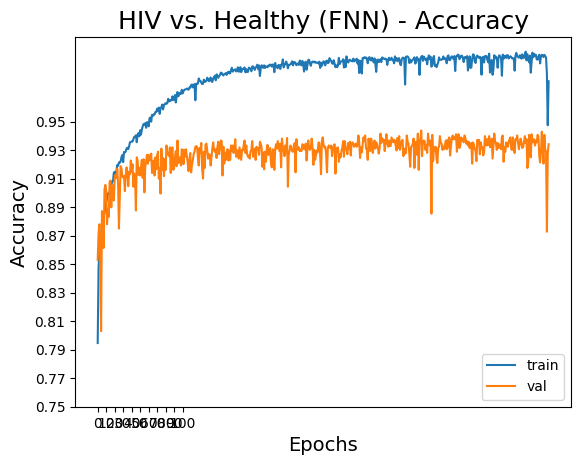

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('HIV vs. Healthys - Protein LM', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.yticks(np.arange(0.75, 0.96, 0.02))
plt.xticks(np.arange(0, 108, 10.0))
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Model 3 Testing

In [22]:
model.save("hiv_model_reserve.h5")

In [23]:
with open('hiv_history_reserve.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [2]:
with open('hiv_history_reserve.pkl', 'rb') as file_pi:
    history = pickle.load(file_pi)

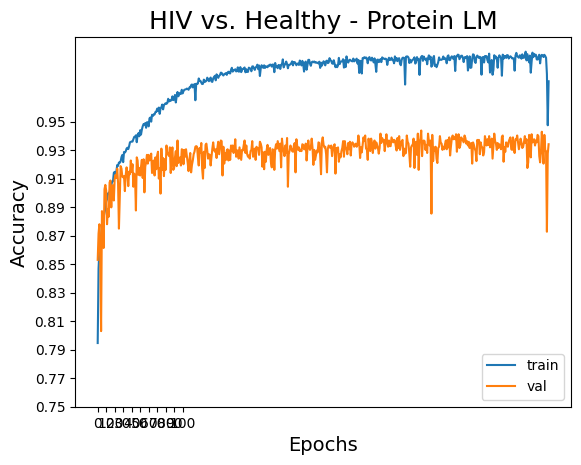

In [4]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('HIV vs. Healthy - Protein LM', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.yticks(np.arange(0.75, 0.96, 0.02))
plt.xticks(np.arange(0, 108, 10.0))
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [30]:
model.evaluate(X_test, y_test)

2023-02-02 17:02:18.218878: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-02 17:02:18.539274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - 2s 10ms/step - loss: 0.5046 - accuracy: 0.9392


[0.5046305060386658, 0.9392025470733643]

In [29]:
model = tf.keras.models.load_model("hiv_model_reserve.h5")

In [31]:
y_pred = []
y_true = y_test

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

1/1 [==============================] - 0s 15ms/step


2023-02-02 17:02:22.384775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 17ms/step


[array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([

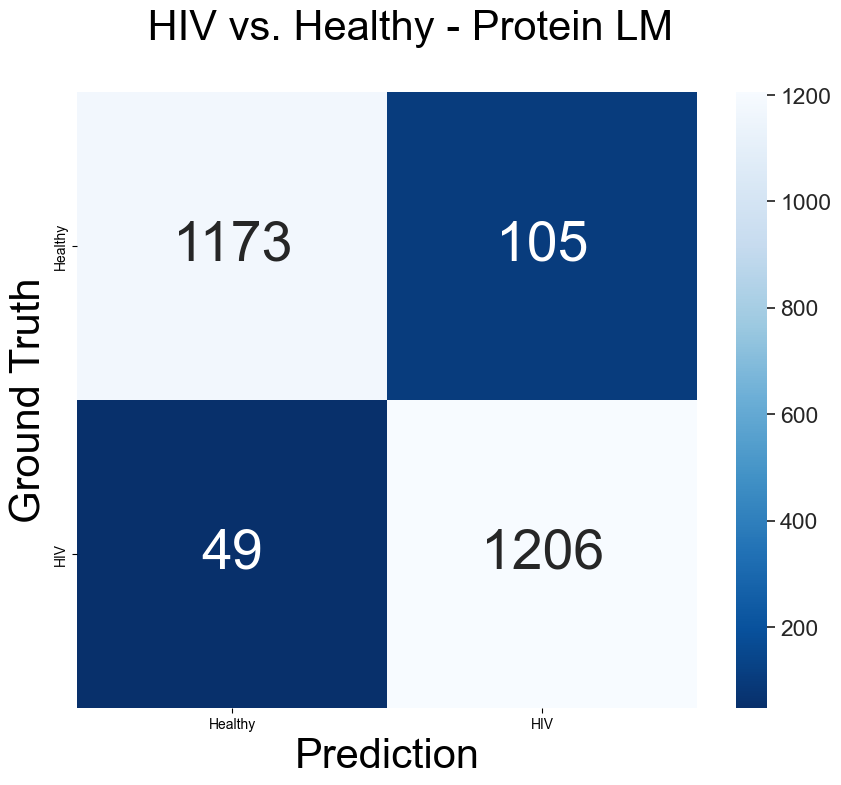

tf.Tensor(
[[1173  105]
 [  49 1206]], shape=(2, 2), dtype=int32)


In [32]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
plt.title('    HIV vs. Healthy - Protein LM\n', fontsize=30)
sns.set(font_scale=1.5)

cmap = sns.color_palette("Blues_r", as_cmap=True)

sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "HIV"],
            yticklabels=["Healthy", "HIV"],
            annot=True, fmt='g', annot_kws={"size":40}, cmap=cmap)
plt.xlabel('Prediction', fontsize=30)
plt.ylabel('Ground Truth', fontsize=30)
plt.show()

print(confusion_mtx)

In [33]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

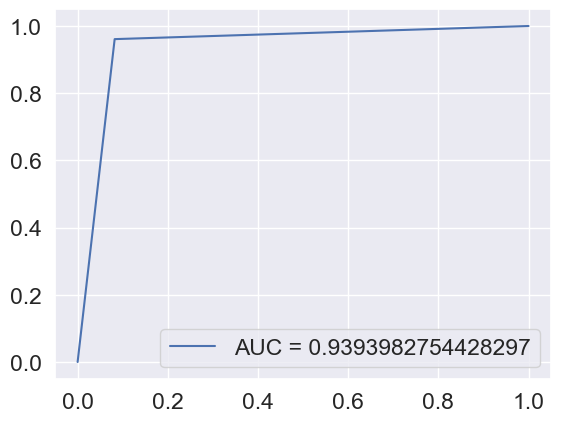

In [27]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()